# 01_EDA - Exploratory Data Analysis

This notebook loads the dataset using `src/load_data.py`, prints basic information, and creates simple plots (class distribution, amount distribution, correlation heatmap). If no CSV is found in `../data/raw/`, it will ask you to place the file there.

In [123]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..', 'src')))
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from load_data import load_dataset, save_sample

RAW_DIR = os.path.abspath(os.path.join('..', 'data', 'raw'))

# Look for the original SAML-D.csv file (not balanced_data.csv)
dataset_path = os.path.join(RAW_DIR, 'SAML-D.csv')

if not os.path.exists(dataset_path):
    print(f'ERROR: {dataset_path} not found!')
    print('Please ensure SAML-D.csv is in the data/raw directory.')
else:
    print(f'Loading full dataset from: {dataset_path}')
    df = load_dataset(dataset_path)
    save_sample(df, os.path.join(RAW_DIR, 'sample.csv'), sample_size=500)
    print(f'✅ Loaded dataset with {len(df):,} rows and {len(df.columns)} columns.')


Loading full dataset from: c:\Users\mazen\Desktop\Uni\Term 9\Data Mining\Anti-Money Laundering (AML) Detection System\aml_project\data\raw\SAML-D.csv
Loading dataset from: c:\Users\mazen\Desktop\Uni\Term 9\Data Mining\Anti-Money Laundering (AML) Detection System\aml_project\data\raw\SAML-D.csv

Dataset loaded successfully!
Shape: 9504852 rows, 12 columns

First 5 rows:
       Time        Date  Sender_account  Receiver_account    Amount  \
0  10:35:19  2022-10-07      8724731955        2769355426   1459.15   
1  10:35:20  2022-10-07      1491989064        8401255335   6019.64   
2  10:35:20  2022-10-07       287305149        4404767002  14328.44   
3  10:35:21  2022-10-07      5376652437        9600420220  11895.00   
4  10:35:21  2022-10-07      9614186178        3803336972    115.25   

  Payment_currency Received_currency Sender_bank_location  \
0        UK pounds         UK pounds                   UK   
1        UK pounds            Dirham                   UK   
2        UK pounds

## Data Preparation and Class Balancing

Drop unnecessary columns and balance the dataset to improve model performance and clustering quality.

In [124]:
# Step 1: Drop Laundering_type column (we only need Is_laundering for binary classification)
if 'Laundering_type' in df.columns:
    df = df.drop(columns=['Laundering_type'])
    print('Dropped Laundering_type column')

# Step 2: Check current class distribution
print('\nOriginal class distribution:')
print(df['Is_laundering'].value_counts())
print(f'\nClass proportions:')
print(df['Is_laundering'].value_counts(normalize=True))
print(f'\nOriginal ratio (legitimate:fraud): {(df["Is_laundering"]==0).sum()/(df["Is_laundering"]==1).sum():.1f}:1')

Dropped Laundering_type column

Original class distribution:
Is_laundering
0    9494979
1       9873
Name: count, dtype: int64

Class proportions:
Is_laundering
0    0.998961
1    0.001039
Name: proportion, dtype: float64

Original ratio (legitimate:fraud): 961.7:1


In [125]:
# Step 3: Balance the dataset using stratified undersampling
# Strategy: Keep ALL fraud cases (minority class) and undersample legitimate transactions
# Target ratio: 5:1 (legitimate:fraud) for better model learning

fraud_cases = df[df['Is_laundering'] == 1]
legitimate_cases = df[df['Is_laundering'] == 0]

n_fraud = len(fraud_cases)
target_ratio = 5  # 5 legitimate for every 1 fraud
n_legitimate_target = n_fraud * target_ratio

print(f'\nBalancing strategy:')
print(f'  Keep all fraud cases: {n_fraud:,}')
print(f'  Target ratio: {target_ratio}:1 (legitimate:fraud)')
print(f'  Undersample legitimate to: {n_legitimate_target:,}')

# Randomly sample legitimate cases
legitimate_sampled = legitimate_cases.sample(n=n_legitimate_target, random_state=42)

# Combine fraud and sampled legitimate cases
df_balanced = pd.concat([fraud_cases, legitimate_sampled], ignore_index=True)

# Shuffle the dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print(f'\nBalanced dataset:')
print(df_balanced['Is_laundering'].value_counts())
print(f'\nNew class proportions:')
print(df_balanced['Is_laundering'].value_counts(normalize=True))
print(f'\nNew ratio (legitimate:fraud): {(df_balanced["Is_laundering"]==0).sum()/(df_balanced["Is_laundering"]==1).sum():.1f}:1')
print(f'\nDataset size reduced from {len(df):,} to {len(df_balanced):,} ({100*len(df_balanced)/len(df):.2f}%)')

# Replace df with balanced version
df = df_balanced

# Save balanced dataset for use in subsequent notebooks
balanced_path = os.path.join(RAW_DIR, 'balanced_data.csv')
df.to_csv(balanced_path, index=False)
print(f'\n✅ Balanced dataset saved to: {balanced_path}')
print(f'   Use this file in preprocessing notebook (02_preprocessing.ipynb)')



Balancing strategy:
  Keep all fraud cases: 9,873
  Target ratio: 5:1 (legitimate:fraud)
  Undersample legitimate to: 49,365

Balanced dataset:
Is_laundering
0    49365
1     9873
Name: count, dtype: int64

New class proportions:
Is_laundering
0    0.833333
1    0.166667
Name: proportion, dtype: float64

New ratio (legitimate:fraud): 5.0:1

Dataset size reduced from 9,504,852 to 59,238 (0.62%)

Balanced dataset:
Is_laundering
0    49365
1     9873
Name: count, dtype: int64

New class proportions:
Is_laundering
0    0.833333
1    0.166667
Name: proportion, dtype: float64

New ratio (legitimate:fraud): 5.0:1

Dataset size reduced from 9,504,852 to 59,238 (0.62%)

✅ Balanced dataset saved to: c:\Users\mazen\Desktop\Uni\Term 9\Data Mining\Anti-Money Laundering (AML) Detection System\aml_project\data\raw\balanced_data.csv
   Use this file in preprocessing notebook (02_preprocessing.ipynb)

✅ Balanced dataset saved to: c:\Users\mazen\Desktop\Uni\Term 9\Data Mining\Anti-Money Laundering (AML

## Dataset Info

In [126]:
print('\nInfo:')
print(df.info())

print('\nDescribe:')
display(df.describe(include='all'))


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59238 entries, 0 to 59237
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Time                    59238 non-null  object 
 1   Date                    59238 non-null  object 
 2   Sender_account          59238 non-null  int64  
 3   Receiver_account        59238 non-null  int64  
 4   Amount                  59238 non-null  float64
 5   Payment_currency        59238 non-null  object 
 6   Received_currency       59238 non-null  object 
 7   Sender_bank_location    59238 non-null  object 
 8   Receiver_bank_location  59238 non-null  object 
 9   Payment_type            59238 non-null  object 
 10  Is_laundering           59238 non-null  int64  
dtypes: float64(1), int64(3), object(7)
memory usage: 5.0+ MB
None

Describe:


,Time,Date,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Is_laundering
count,59238,59238,5.923800e+04,5.923800e+04,5.923800e+04,59238,59238,59238,59238,59238,59238.000000
unique,40285,321,NaN,NaN,NaN,13,13,18,18,7,NaN
top,09:03:43,2023-02-09,NaN,NaN,NaN,UK pounds,UK pounds,UK,UK,ACH,NaN
freq,7,250,NaN,NaN,NaN,56028,52502,56899,53313,11676,NaN
mean,NaN,NaN,5.038136e+09,5.009185e+09,1.390866e+04,NaN,NaN,NaN,NaN,NaN,0.166667
std,NaN,NaN,2.882089e+09,2.883052e+09,1.723923e+05,NaN,NaN,NaN,NaN,NaN,0.372681
min,NaN,NaN,9.217200e+04,9.217200e+04,5.450000e+00,NaN,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,2.567179e+09,2.509965e+09,2.268630e+03,NaN,NaN,NaN,NaN,NaN,0.000000
50%,NaN,NaN,5.020346e+09,5.005141e+09,6.008690e+03,NaN,NaN,NaN,NaN,NaN,0.000000
75%,NaN,NaN,7.535182e+09,7.510516e+09,1.036717e+04,NaN,NaN,NaN,NaN,NaN,0.000000


## Class Distribution (is_laundring)

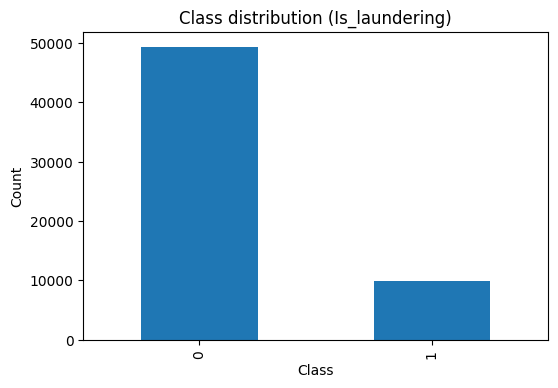


Class counts:
Is_laundering
0    49365
1     9873
Name: count, dtype: int64


In [127]:
if 'Is_laundering' in df.columns:
    counts = df['Is_laundering'].value_counts(dropna=False)
    plt.figure(figsize=(6,4))
    counts.plot(kind='bar')
    plt.title('Class distribution (Is_laundering)')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.show()
    print(f'\nClass counts:\n{counts}')
else:
    print('Column "Is_laundering" not found in dataset.')

## Correlation Heatmap (All Features)

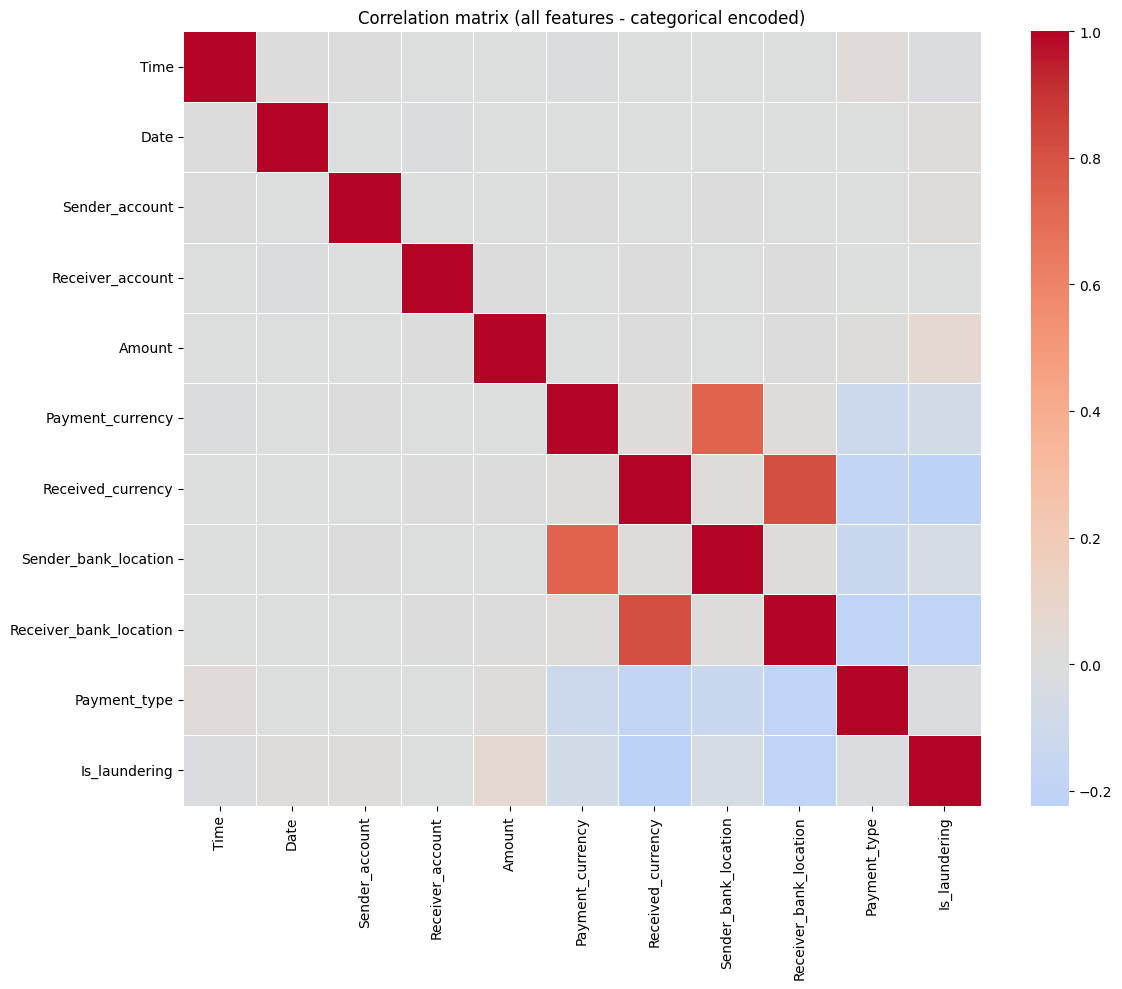

In [128]:
# Create a copy for encoding
df_encoded = df.copy()

# Encode categorical/object columns as numeric
for col in df_encoded.columns:
    if df_encoded[col].dtype == 'object' or df_encoded[col].dtype.name == 'category':
        df_encoded[col] = pd.Categorical(df_encoded[col]).codes

# Calculate correlation matrix
if df_encoded.shape[1] >= 2:
    corr = df_encoded.corr()
    plt.figure(figsize=(12,10))
    sns.heatmap(corr, cmap='coolwarm', center=0, linewidths=0.5, annot=False, fmt='.2f')
    plt.title('Correlation matrix (all features - categorical encoded)')
    plt.tight_layout()
    plt.show()
else:
    print('Not enough columns for correlation matrix.')

## Feature Distributions

Visualize the distribution of key numerical features to understand their shapes.

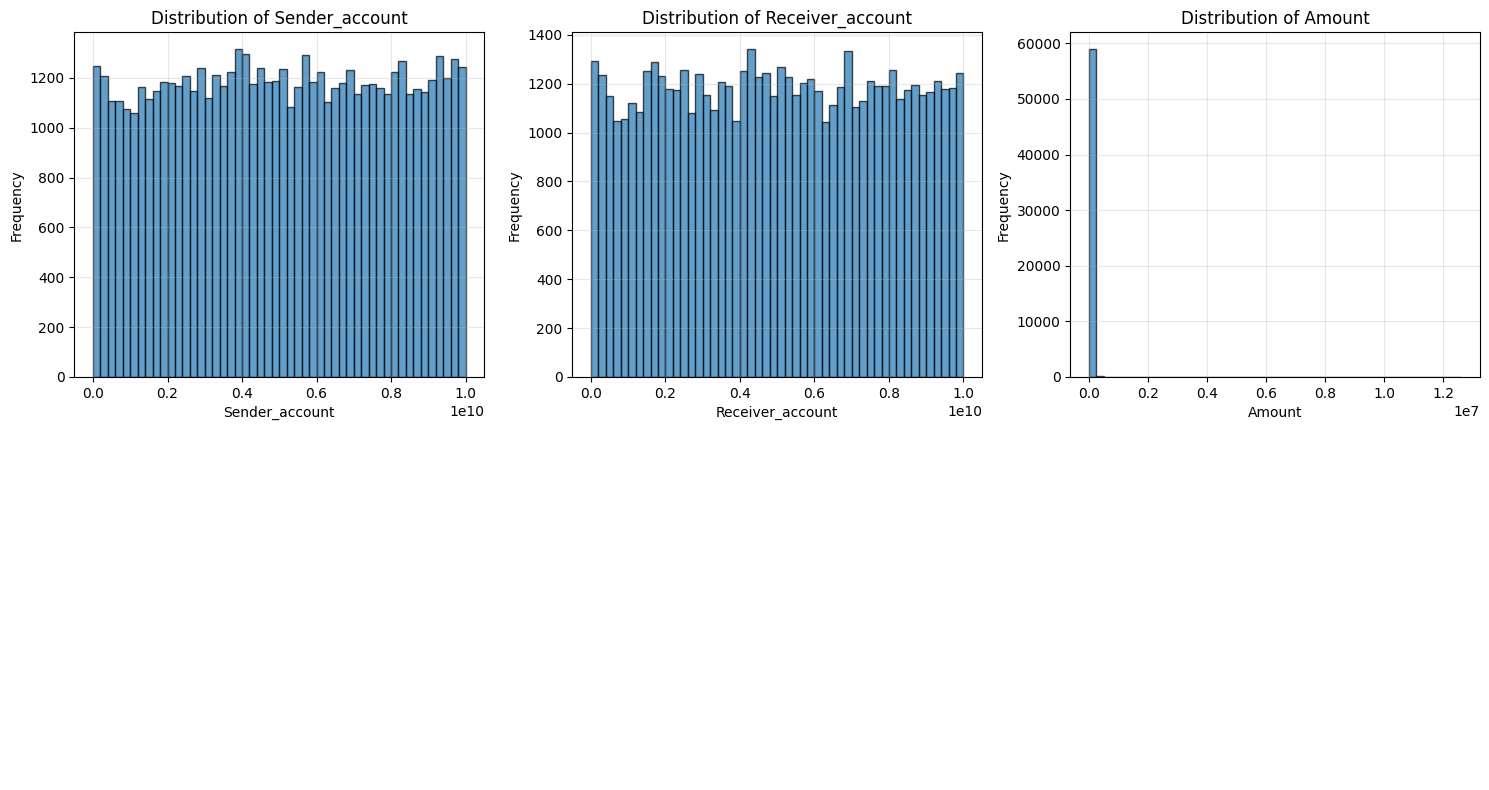

In [129]:
# Get numerical columns only
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Remove label columns if present
numerical_cols = [col for col in numerical_cols if col not in ['Is_laundering']]

# Plot distributions for the first 6 numerical features
num_features_to_plot = min(6, len(numerical_cols))

if num_features_to_plot > 0:
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.flatten()
    
    for i in range(num_features_to_plot):
        col = numerical_cols[i]
        axes[i].hist(df[col].dropna(), bins=50, edgecolor='black', alpha=0.7)
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')
        axes[i].grid(True, alpha=0.3)
    
    # Hide empty subplots if we have fewer than 6 features
    for i in range(num_features_to_plot, 6):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print('No numerical columns found for plotting.')

## Box Plots for Outlier Detection

Use box plots to visualize the spread and identify outliers in numerical features.

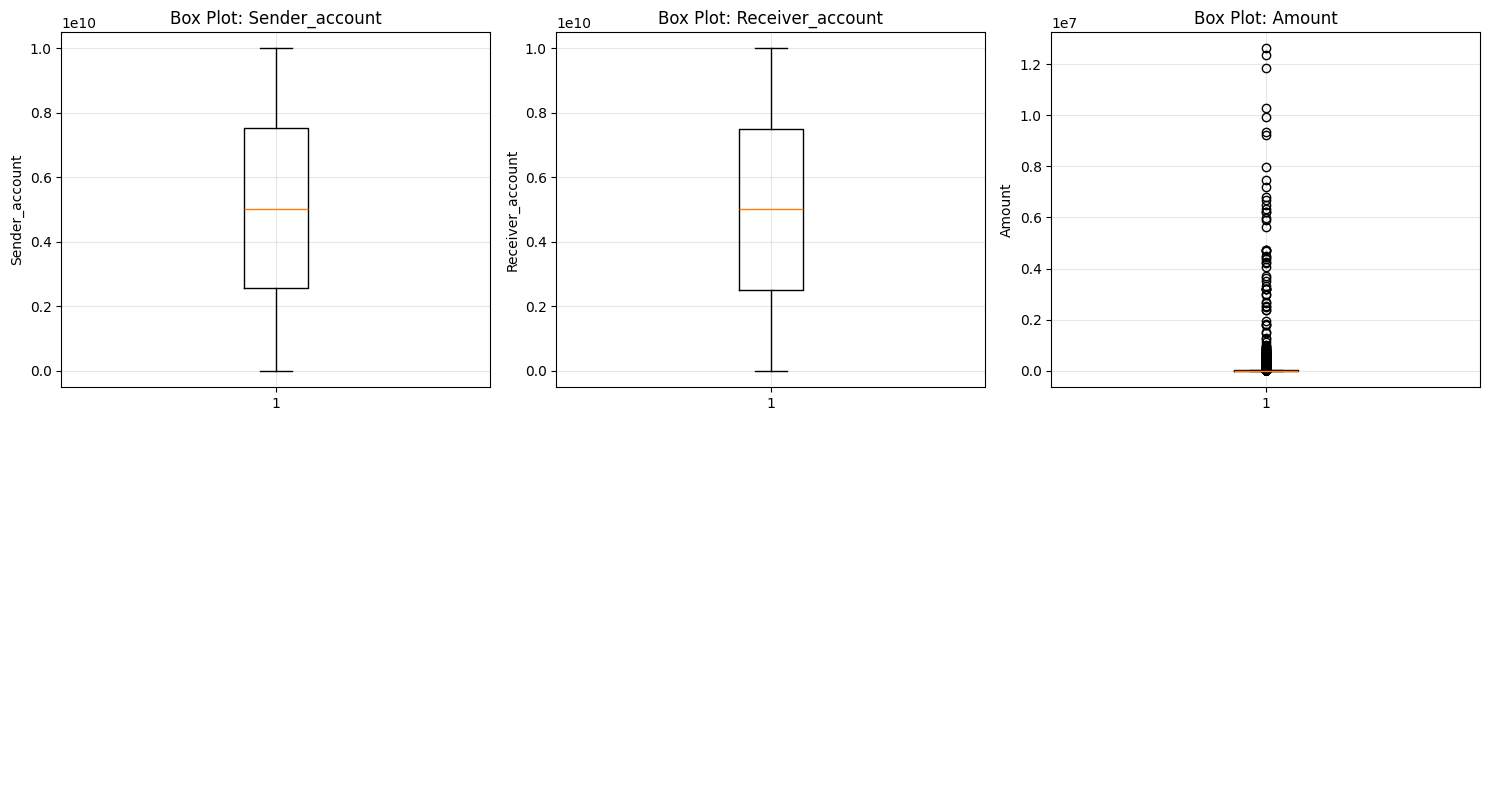

In [130]:
# Box plots for numerical features
if num_features_to_plot > 0:
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.flatten()
    
    for i in range(num_features_to_plot):
        col = numerical_cols[i]
        axes[i].boxplot(df[col].dropna(), vert=True)
        axes[i].set_title(f'Box Plot: {col}')
        axes[i].set_ylabel(col)
        axes[i].grid(True, alpha=0.3)
    
    # Hide empty subplots if we have fewer than 6 features
    for i in range(num_features_to_plot, 6):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print('No numerical columns found for plotting.')

## Pairwise Scatter Plots

Visualize relationships between key features using scatter plots.

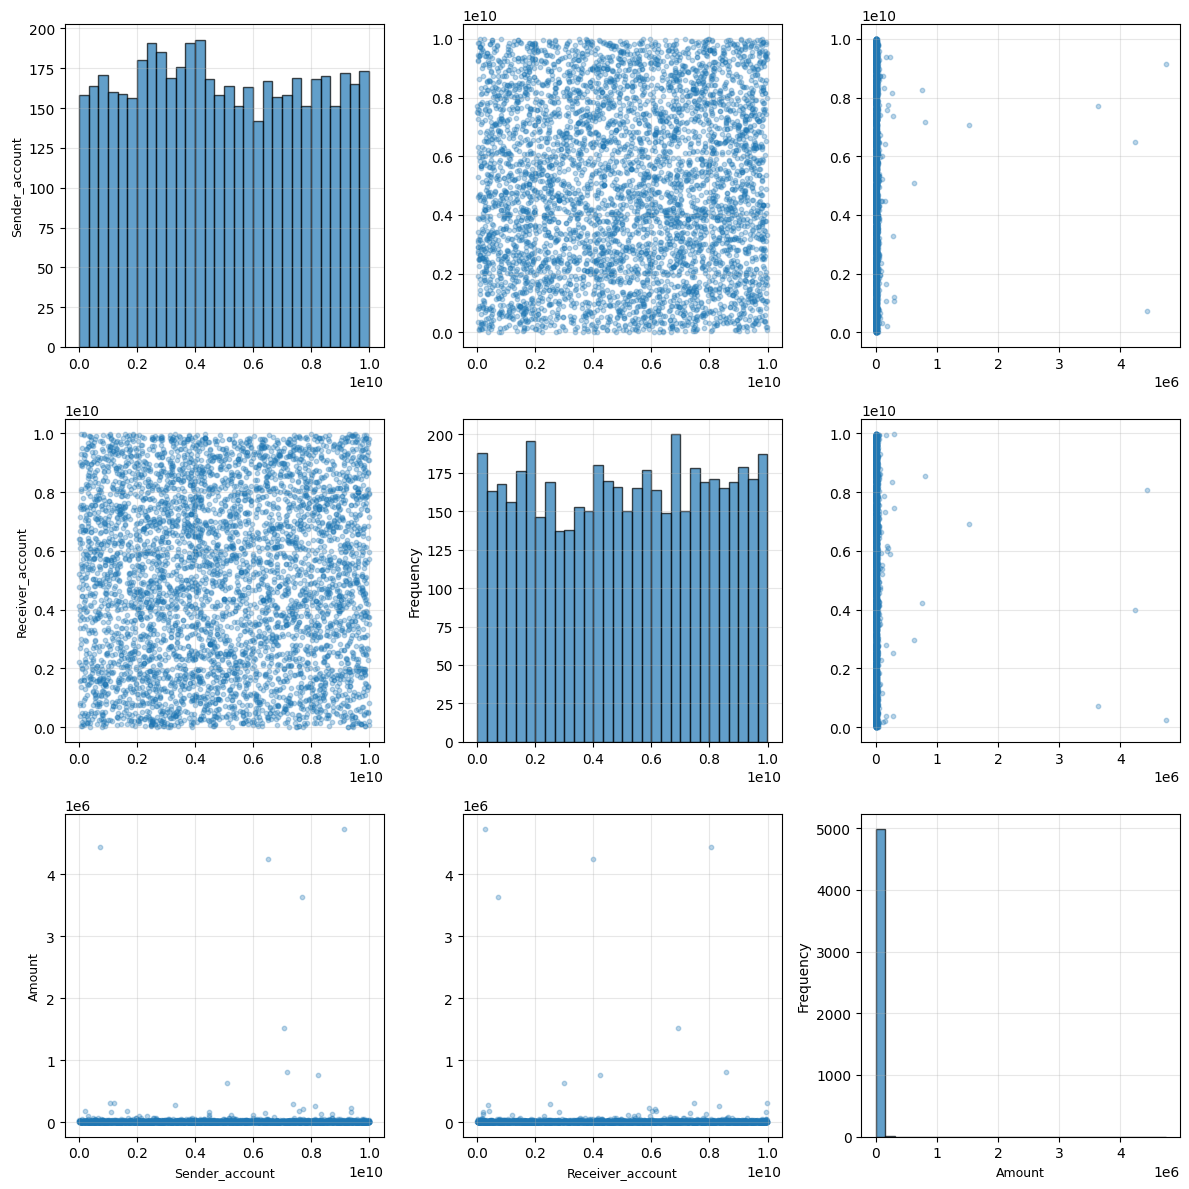

In [131]:
# Scatter plots between first 4 numerical features
if len(numerical_cols) >= 2:
    # Sample data for faster plotting if dataset is large
    sample_df = df[numerical_cols[:4]].sample(n=min(5000, len(df)), random_state=42)
    
    # Create pairplot for first 4 features
    num_cols_to_plot = min(4, len(numerical_cols))
    cols_to_plot = numerical_cols[:num_cols_to_plot]
    
    fig, axes = plt.subplots(num_cols_to_plot, num_cols_to_plot, figsize=(12, 12))
    
    for i in range(num_cols_to_plot):
        for j in range(num_cols_to_plot):
            if i == j:
                # Diagonal: plot histogram
                axes[i, j].hist(sample_df[cols_to_plot[i]].dropna(), bins=30, alpha=0.7, edgecolor='black')
                axes[i, j].set_ylabel('Frequency')
            else:
                # Off-diagonal: scatter plot
                axes[i, j].scatter(sample_df[cols_to_plot[j]], sample_df[cols_to_plot[i]], 
                                  alpha=0.3, s=10)
            
            # Set labels
            if i == num_cols_to_plot - 1:
                axes[i, j].set_xlabel(cols_to_plot[j], fontsize=9)
            if j == 0:
                axes[i, j].set_ylabel(cols_to_plot[i], fontsize=9)
            
            axes[i, j].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print('Not enough numerical columns for pairwise plots.')

# Clustering Analysis: K-means and DBSCAN

In this section, we'll implement K-means and DBSCAN clustering algorithms both manually and using sklearn. We'll sample a reasonable number of records from the dataset for visualization and analysis.

## Prepare Data for Clustering

Sample 5,000 random records from the dataset and prepare the features for clustering by dropping the label columns.

In [132]:
# Sample random records for clustering (now from balanced dataset)
# Adjust sample size based on balanced dataset size
sample_size = min(len(df), 60000)  # Use all data if less than 60k, otherwise sample 60k
df_sample = df.sample(n=sample_size, random_state=42)

print(f'Sampled {sample_size:,} records from balanced dataset of {len(df):,}')

# Drop label column (Laundering_type already dropped earlier)
columns_to_drop = ['Is_laundering']
df_clustering = df_sample.drop(columns=[col for col in columns_to_drop if col in df_sample.columns], errors='ignore')

# Convert categorical columns to numeric
df_clustering_encoded = df_clustering.copy()
for col in df_clustering_encoded.columns:
    if df_clustering_encoded[col].dtype == 'object' or df_clustering_encoded[col].dtype.name == 'category':
        df_clustering_encoded[col] = pd.Categorical(df_clustering_encoded[col]).codes

# Fill any missing values with column mean
df_clustering_encoded = df_clustering_encoded.fillna(df_clustering_encoded.mean())

print(f'Prepared {len(df_clustering_encoded)} samples with {len(df_clustering_encoded.columns)} features for clustering')
print(f'Feature names: {list(df_clustering_encoded.columns)}')

Sampled 59,238 records from balanced dataset of 59,238
Prepared 59238 samples with 10 features for clustering
Feature names: ['Time', 'Date', 'Sender_account', 'Receiver_account', 'Amount', 'Payment_currency', 'Received_currency', 'Sender_bank_location', 'Receiver_bank_location', 'Payment_type']


## Standardize Features

Standardize the features to have mean=0 and std=1 for better clustering performance.

In [133]:
# Standardize features manually
X = df_clustering_encoded.values
mean = X.mean(axis=0)
std = X.std(axis=0)
X_scaled = (X - mean) / (std + 1e-10)  # Add small value to avoid division by zero

print(f'Standardized data shape: {X_scaled.shape}')
print(f'Mean of scaled data: {X_scaled.mean(axis=0)[:5]}...')  # Show first 5
print(f'Std of scaled data: {X_scaled.std(axis=0)[:5]}...')  # Show first 5

Standardized data shape: (59238, 10)
Mean of scaled data: [-7.34676096e-17  7.53267899e-17  1.06992829e-16  1.27623733e-16
  1.63128080e-17]...
Std of scaled data: [1. 1. 1. 1. 1.]...


## Manual K-means Implementation

Implement K-means clustering from scratch using basic distance calculations and iterative centroid updates.

In [134]:
def manual_kmeans(X, k, max_iterations=100):
    """
    Simple K-means clustering implementation
    
    X: data array (n_samples, n_features)
    k: number of clusters
    max_iterations: maximum number of iterations
    
    Returns: cluster labels for each point
    """
    n_samples = X.shape[0]
    
    # Step 1: Initialize centroids randomly by picking k random points
    random_indices = np.random.choice(n_samples, k, replace=False)
    centroids = X[random_indices].copy()
    
    for iteration in range(max_iterations):
        # Step 2: Assign each point to nearest centroid
        labels = np.zeros(n_samples)
        
        for i in range(n_samples):
            # Calculate distance from point to each centroid
            distances = np.zeros(k)
            for j in range(k):
                diff = X[i] - centroids[j]
                distances[j] = np.sqrt(np.sum(diff ** 2))  # Euclidean distance
            
            # Assign to closest centroid
            labels[i] = np.argmin(distances)
        
        # Step 3: Update centroids by calculating mean of assigned points
        new_centroids = np.zeros_like(centroids)
        for j in range(k):
            points_in_cluster = X[labels == j]
            if len(points_in_cluster) > 0:
                new_centroids[j] = points_in_cluster.mean(axis=0)
            else:
                new_centroids[j] = centroids[j]  # Keep old centroid if no points assigned
        
        # Check if centroids changed
        if np.allclose(centroids, new_centroids):
            print(f'Converged at iteration {iteration}')
            break
        
        centroids = new_centroids
    
    return labels.astype(int), centroids

# Test manual K-means with k=3
print('Running manual K-means with k=3...')
np.random.seed(42)
manual_kmeans_labels, manual_centroids = manual_kmeans(X_scaled, k=3)
print(f'Cluster distribution: {np.bincount(manual_kmeans_labels)}')

Running manual K-means with k=3...
Converged at iteration 24
Cluster distribution: [26461  6190 26587]
Converged at iteration 24
Cluster distribution: [26461  6190 26587]


## Sklearn K-means with Elbow Method

Use the elbow method to find the optimal number of clusters by plotting inertia (sum of squared distances) for different k values.

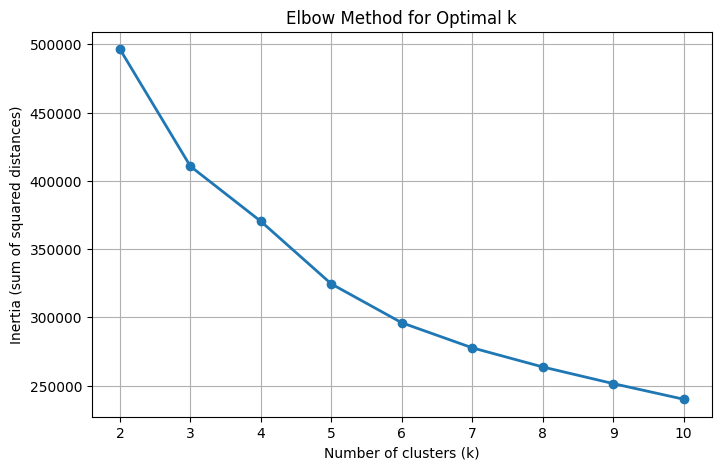

Inertia values for different k:
k=2: 496418.26
k=3: 410651.46
k=4: 370321.83
k=5: 324474.54
k=6: 296023.67
k=7: 277674.92
k=8: 263657.62
k=9: 251468.42
k=10: 240007.92


In [135]:
from sklearn.cluster import KMeans

# Elbow method: try different k values and plot inertia
k_values = range(2, 11)
inertias = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertias, marker='o', linewidth=2)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (sum of squared distances)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

print('Inertia values for different k:')
for k, inertia in zip(k_values, inertias):
    print(f'k={k}: {inertia:.2f}')

In [136]:
# Use optimal k (let's say k=5 from elbow) and run sklearn K-means
optimal_k = 5
sklearn_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
sklearn_kmeans_labels = sklearn_kmeans.fit_predict(X_scaled)

print(f'\nSklearn K-means with k={optimal_k}')
print(f'Cluster distribution: {np.bincount(sklearn_kmeans_labels)}')


Sklearn K-means with k=4
Cluster distribution: [36251  4419  1885 16683]


## Manual DBSCAN Implementation

Implement DBSCAN (Density-Based Spatial Clustering) from scratch. DBSCAN groups points that are close together and marks isolated points as noise.

In [137]:
def manual_dbscan(X, eps, min_samples):
    """
    Simple DBSCAN clustering implementation
    
    X: data array (n_samples, n_features)
    eps: maximum distance between two points to be neighbors
    min_samples: minimum points to form a dense region
    
    Returns: cluster labels (-1 for noise)
    """
    n_samples = X.shape[0]
    labels = np.full(n_samples, -1)  # Initialize all as noise (-1)
    cluster_id = 0
    
    # Helper function to find neighbors within eps distance
    def find_neighbors(point_idx):
        neighbors = []
        for i in range(n_samples):
            if i != point_idx:
                diff = X[point_idx] - X[i]
                distance = np.sqrt(np.sum(diff ** 2))
                if distance <= eps:
                    neighbors.append(i)
        return neighbors
    
    # Process each point
    for i in range(n_samples):
        # Skip if already assigned to cluster
        if labels[i] != -1:
            continue
        
        # Find neighbors
        neighbors = find_neighbors(i)
        
        # Not enough neighbors = noise point
        if len(neighbors) < min_samples:
            continue
        
        # Start new cluster
        labels[i] = cluster_id
        
        # Expand cluster by processing neighbors
        j = 0
        while j < len(neighbors):
            neighbor_idx = neighbors[j]
            
            # Assign noise points to cluster
            if labels[neighbor_idx] == -1:
                labels[neighbor_idx] = cluster_id
            
            # Skip if already in a cluster
            if labels[neighbor_idx] != -1:
                j += 1
                continue
            
            # Assign to cluster
            labels[neighbor_idx] = cluster_id
            
            # Find this neighbor's neighbors
            neighbor_neighbors = find_neighbors(neighbor_idx)
            
            # If it's a core point, add its neighbors to expansion list
            if len(neighbor_neighbors) >= min_samples:
                neighbors.extend(neighbor_neighbors)
            
            j += 1
        
        cluster_id += 1
    
    return labels

# Test manual DBSCAN with sample parameters
print('Running manual DBSCAN (this may take a moment)...')
# Use smaller sample for manual DBSCAN since it's slow
X_small = X_scaled[:1000]  # Use first 1000 points
np.random.seed(42)
manual_dbscan_labels = manual_dbscan(X_small, eps=1.5, min_samples=5)
unique_labels = np.unique(manual_dbscan_labels)
n_clusters = len(unique_labels[unique_labels != -1])
n_noise = np.sum(manual_dbscan_labels == -1)
print(f'Number of clusters: {n_clusters}')
print(f'Number of noise points: {n_noise}')

Running manual DBSCAN (this may take a moment)...
Number of clusters: 85
Number of noise points: 144
Number of clusters: 85
Number of noise points: 144


## Find Optimal DBSCAN Parameters using K-Distance Graph

Use the k-distance graph to find the optimal eps value. The elbow point in the k-distance graph suggests the best eps value.

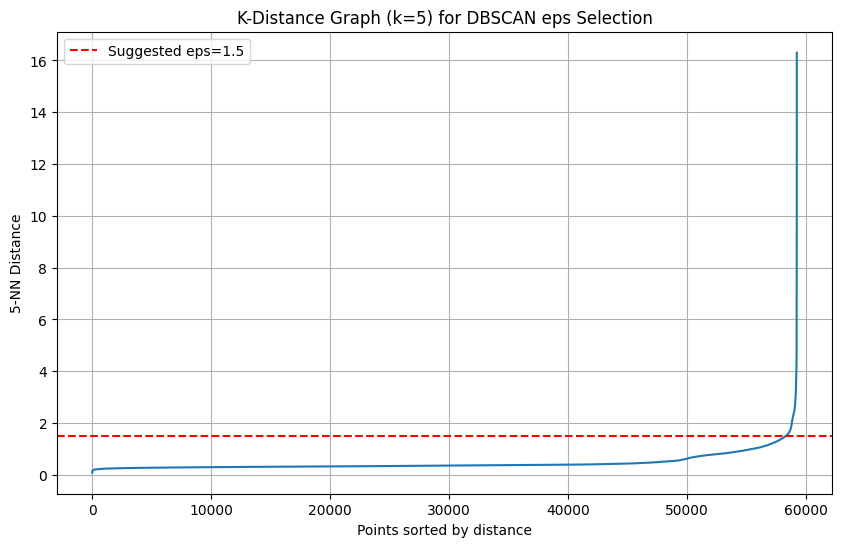

K-distance statistics (k=5):
  Min: 0.0812
  25th percentile: 0.3105
  50th percentile (median): 0.3510
  75th percentile: 0.4277
  90th percentile: 0.8369
  Max: 16.2987

Look for the "elbow" point where the curve starts to rise sharply.
The eps value should be at or slightly before this elbow.


In [138]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

# Choose k (min_samples) - typically use 2 * number of dimensions or 4 as minimum
k = 5  # This will be our min_samples parameter

# Calculate k-nearest neighbors distances
neighbors = NearestNeighbors(n_neighbors=k)
neighbors.fit(X_scaled)
distances, indices = neighbors.kneighbors(X_scaled)

# Get the distance to the k-th nearest neighbor for each point
k_distances = distances[:, -1]

# Sort the distances in ascending order
k_distances_sorted = np.sort(k_distances)

# Plot k-distance graph
plt.figure(figsize=(10, 6))
plt.plot(k_distances_sorted)
plt.xlabel('Points sorted by distance')
plt.ylabel(f'{k}-NN Distance')
plt.title(f'K-Distance Graph (k={k}) for DBSCAN eps Selection')
plt.grid(True)
plt.axhline(y=1.5, color='r', linestyle='--', label='Suggested eps=1.5')
plt.legend()
plt.show()

# Show some statistics to help choose eps
print(f'K-distance statistics (k={k}):')
print(f'  Min: {k_distances_sorted.min():.4f}')
print(f'  25th percentile: {np.percentile(k_distances_sorted, 25):.4f}')
print(f'  50th percentile (median): {np.percentile(k_distances_sorted, 50):.4f}')
print(f'  75th percentile: {np.percentile(k_distances_sorted, 75):.4f}')
print(f'  90th percentile: {np.percentile(k_distances_sorted, 90):.4f}')
print(f'  Max: {k_distances_sorted.max():.4f}')
print(f'\nLook for the "elbow" point where the curve starts to rise sharply.')
print(f'The eps value should be at or slightly before this elbow.')

In [139]:
from sklearn.cluster import DBSCAN

# Based on k-distance graph, choose optimal parameters
best_min_samples = 5  # This is the k we used
best_eps = 2  # Choose based on the elbow in the k-distance graph

print(f'Chosen DBSCAN parameters based on k-distance graph:')
print(f'  eps = {best_eps}')
print(f'  min_samples = {best_min_samples}')

# Run sklearn DBSCAN with optimal parameters on the FULL scaled dataset
print(f'\nRunning DBSCAN on {len(X_scaled):,} samples...')
sklearn_dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
sklearn_dbscan_labels = sklearn_dbscan.fit_predict(X_scaled)

n_clusters_dbscan = len(set(sklearn_dbscan_labels)) - (1 if -1 in sklearn_dbscan_labels else 0)
n_noise_dbscan = list(sklearn_dbscan_labels).count(-1)

print(f'\nSklearn DBSCAN Results:')
print(f'  Number of clusters: {n_clusters_dbscan}')
print(f'  Number of noise points: {n_noise_dbscan}')
print(f'  Percentage noise: {100 * n_noise_dbscan / len(X_scaled):.2f}%')

Chosen DBSCAN parameters based on k-distance graph:
  eps = 2
  min_samples = 5

Running DBSCAN on 59,238 samples...

Sklearn DBSCAN Results:
  Number of clusters: 6
  Number of noise points: 333
  Percentage noise: 0.56%

Sklearn DBSCAN Results:
  Number of clusters: 6
  Number of noise points: 333
  Percentage noise: 0.56%


## Remove Noise Points from Dataset

Filter out the noise points identified by DBSCAN to create a cleaned dataset.

In [140]:
# First, create PCA projection for visualizations (if not already created)
from sklearn.decomposition import PCA

# Always recreate X_pca to ensure it matches current X_scaled
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
print(f'Created PCA projection with {pca.explained_variance_ratio_.sum():.2%} variance explained')
print(f'X_pca shape: {X_pca.shape}')
print(f'sklearn_dbscan_labels shape: {sklearn_dbscan_labels.shape}')

# Identify noise points (label = -1) from DBSCAN
noise_mask = sklearn_dbscan_labels == -1
non_noise_mask = sklearn_dbscan_labels != -1

print(f'Original dataset size: {len(df_sample)}')
print(f'Noise points detected: {noise_mask.sum()} ({100 * noise_mask.sum() / len(df_sample):.2f}%)')
print(f'Clean data points: {non_noise_mask.sum()} ({100 * non_noise_mask.sum() / len(df_sample):.2f}%)')

# Create cleaned dataset by removing noise points
df_cleaned = df_sample[non_noise_mask].copy()

print(f'\nCleaned dataset size: {len(df_cleaned)}')
print(f'Removed {len(df_sample) - len(df_cleaned)} noise points')

# Save cleaned data to CSV
cleaned_data_path = os.path.join(RAW_DIR, 'cleaned_data.csv')
df_cleaned.to_csv(cleaned_data_path, index=False)
print(f'\nCleaned data saved to: {cleaned_data_path}')


Created PCA projection with 36.64% variance explained
X_pca shape: (59238, 2)
sklearn_dbscan_labels shape: (59238,)
Original dataset size: 59238
Noise points detected: 333 (0.56%)
Clean data points: 58905 (99.44%)

Cleaned dataset size: 58905
Removed 333 noise points

Cleaned data saved to: c:\Users\mazen\Desktop\Uni\Term 9\Data Mining\Anti-Money Laundering (AML) Detection System\aml_project\data\raw\cleaned_data.csv

Cleaned data saved to: c:\Users\mazen\Desktop\Uni\Term 9\Data Mining\Anti-Money Laundering (AML) Detection System\aml_project\data\raw\cleaned_data.csv


## Visualize Data Before and After Noise Removal

Compare the data distribution before and after removing noise points.

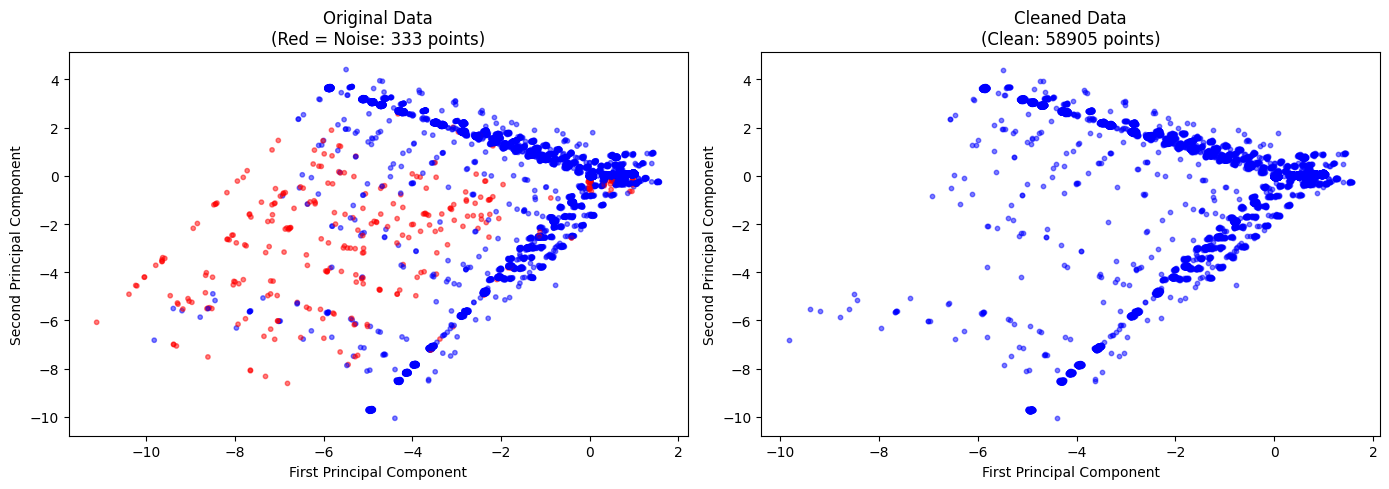


Data cleaning summary:
  Original size: 59,238 samples
  Noise removed: 333 samples (0.56%)
  Final size: 58,905 samples (99.44%)


In [141]:
# Visualize original vs cleaned data in PCA space
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Original data with noise highlighted
colors_original = ['red' if label == -1 else 'blue' for label in sklearn_dbscan_labels]
axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=colors_original, alpha=0.5, s=10)
axes[0].set_title(f'Original Data\n(Red = Noise: {noise_mask.sum()} points)')
axes[0].set_xlabel('First Principal Component')
axes[0].set_ylabel('Second Principal Component')

# Cleaned data (noise removed)
X_pca_cleaned = X_pca[non_noise_mask]
axes[1].scatter(X_pca_cleaned[:, 0], X_pca_cleaned[:, 1], c='blue', alpha=0.5, s=10)
axes[1].set_title(f'Cleaned Data\n(Clean: {non_noise_mask.sum()} points)')
axes[1].set_xlabel('First Principal Component')
axes[1].set_ylabel('Second Principal Component')

plt.tight_layout()
plt.show()

print(f'\nData cleaning summary:')
print(f'  Original size: {len(df_sample):,} samples')
print(f'  Noise removed: {noise_mask.sum():,} samples ({100 * noise_mask.sum() / len(df_sample):.2f}%)')
print(f'  Final size: {len(df_cleaned):,} samples ({100 * len(df_cleaned) / len(df_sample):.2f}%)')

## Visualize K-means Results (Manual vs Sklearn)

Compare the clustering results from manual K-means and sklearn K-means using scatter plots with the first two principal components.

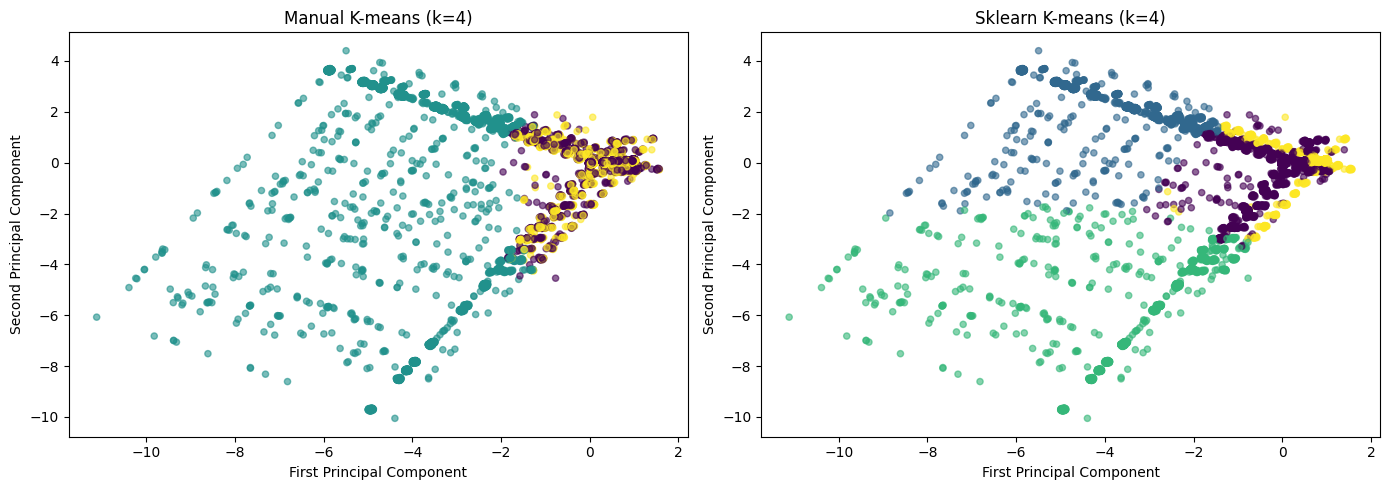

Explained variance by 2 components: 36.64%


In [142]:
# Use PCA to reduce to 2D for visualization
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot manual K-means vs sklearn K-means
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Manual K-means
axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=manual_kmeans_labels, cmap='viridis', alpha=0.6, s=20)
axes[0].set_title('Manual K-means (k=4)')
axes[0].set_xlabel('First Principal Component')
axes[0].set_ylabel('Second Principal Component')

# Sklearn K-means
axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=sklearn_kmeans_labels, cmap='viridis', alpha=0.6, s=20)
axes[1].set_title('Sklearn K-means (k=4)')
axes[1].set_xlabel('First Principal Component')
axes[1].set_ylabel('Second Principal Component')

plt.tight_layout()
plt.show()

print(f'Explained variance by 2 components: {pca.explained_variance_ratio_.sum():.2%}')

## Visualize DBSCAN Results (Manual vs Sklearn)

Compare manual DBSCAN and sklearn DBSCAN results. Note: manual DBSCAN uses only 1000 samples due to computational complexity.

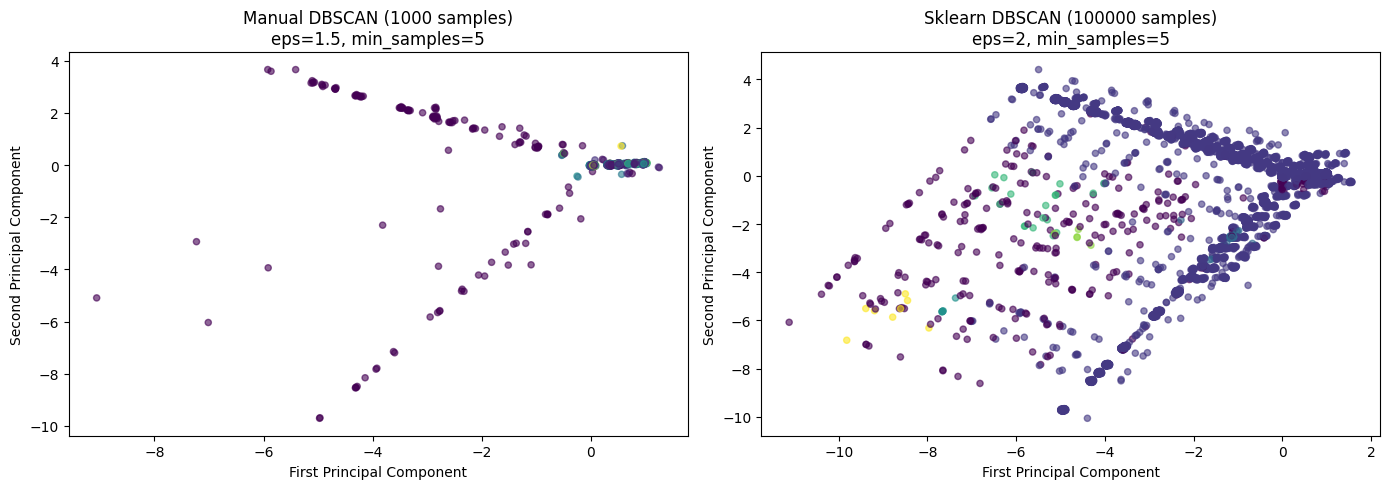

In [143]:
# Visualize DBSCAN results
X_pca_small = X_pca[:1000]  # For manual DBSCAN visualization

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Manual DBSCAN (1000 samples)
scatter1 = axes[0].scatter(X_pca_small[:, 0], X_pca_small[:, 1], 
                           c=manual_dbscan_labels, cmap='viridis', alpha=0.6, s=20)
axes[0].set_title(f'Manual DBSCAN (1000 samples)\neps=1.5, min_samples=5')
axes[0].set_xlabel('First Principal Component')
axes[0].set_ylabel('Second Principal Component')

# Sklearn DBSCAN (all samples)
scatter2 = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], 
                           c=sklearn_dbscan_labels, cmap='viridis', alpha=0.6, s=20)
axes[1].set_title(f'Sklearn DBSCAN (100000 samples)\neps={best_eps}, min_samples={best_min_samples}')
axes[1].set_xlabel('First Principal Component')
axes[1].set_ylabel('Second Principal Component')

plt.tight_layout()
plt.show()

# Gaussian Mixture Models (GMM)

GMM is a probabilistic clustering algorithm that assumes data comes from a mixture of Gaussian distributions. Unlike K-means (hard clustering), GMM provides soft clustering where each point has a probability of belonging to each cluster. GMM is particularly useful for:
- Anomaly detection (points with low probability are anomalies)
- Overlapping clusters
- Understanding uncertainty in cluster assignments

Evaluating different numbers of GMM components...


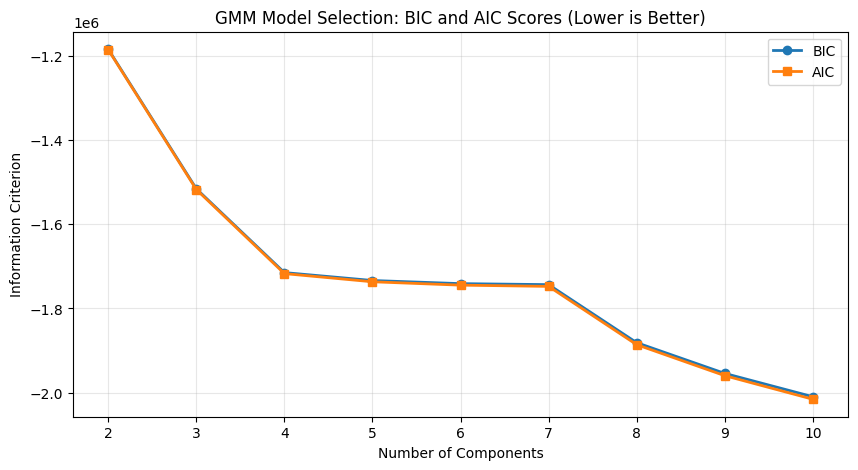


Optimal number of components (by BIC): 10


In [144]:
from sklearn.mixture import GaussianMixture

# Use BIC (Bayesian Information Criterion) to find optimal number of components
n_components_range = range(2, 11)
bic_scores = []
aic_scores = []

print('Evaluating different numbers of GMM components...')
for n in n_components_range:
    gmm = GaussianMixture(n_components=n, random_state=42, covariance_type='full')
    gmm.fit(X_scaled)
    bic_scores.append(gmm.bic(X_scaled))
    aic_scores.append(gmm.aic(X_scaled))

# Plot BIC and AIC scores
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(n_components_range, bic_scores, marker='o', label='BIC', linewidth=2)
ax.plot(n_components_range, aic_scores, marker='s', label='AIC', linewidth=2)
ax.set_xlabel('Number of Components')
ax.set_ylabel('Information Criterion')
ax.set_title('GMM Model Selection: BIC and AIC Scores (Lower is Better)')
ax.legend()
ax.grid(alpha=0.3)
plt.show()

# Find optimal number of components (lowest BIC)
optimal_n_components = n_components_range[np.argmin(bic_scores)]
print(f'\nOptimal number of components (by BIC): {optimal_n_components}')

In [145]:
# Fit GMM with optimal number of components
gmm_optimal = GaussianMixture(n_components=optimal_n_components, random_state=42, covariance_type='full')
gmm_optimal.fit(X_scaled)

# Get cluster predictions (hard clustering)
gmm_labels = gmm_optimal.predict(X_scaled)

# Get probabilities (soft clustering)
gmm_probs = gmm_optimal.predict_proba(X_scaled)

print(f'GMM fitted with {optimal_n_components} components')
print(f'Cluster distribution: {np.bincount(gmm_labels)}')
print(f'\nCluster proportions:')
for i in range(optimal_n_components):
    proportion = (gmm_labels == i).sum() / len(gmm_labels)
    print(f'  Cluster {i}: {proportion:.2%}')

GMM fitted with 10 components
Cluster distribution: [ 2302 14057  8259  9226  5484  2679 11086  1628   640  3877]

Cluster proportions:
  Cluster 0: 3.89%
  Cluster 1: 23.73%
  Cluster 2: 13.94%
  Cluster 3: 15.57%
  Cluster 4: 9.26%
  Cluster 5: 4.52%
  Cluster 6: 18.71%
  Cluster 7: 2.75%
  Cluster 8: 1.08%
  Cluster 9: 6.54%


In [146]:
# Anomaly Detection using GMM
# Points with low probability are potential anomalies

# Calculate log-likelihood for each point (higher is more normal)
log_likelihood = gmm_optimal.score_samples(X_scaled)

# Convert to probability density
probability_density = np.exp(log_likelihood)

# Define anomaly threshold (e.g., bottom 5% as anomalies)
anomaly_threshold_percentile = 5
threshold = np.percentile(probability_density, anomaly_threshold_percentile)

# Identify anomalies
is_anomaly = probability_density < threshold

print(f'Anomaly Detection Results:')
print(f'  Threshold (bottom {anomaly_threshold_percentile}%): {threshold:.6f}')
print(f'  Number of anomalies: {is_anomaly.sum()} ({100*is_anomaly.sum()/len(is_anomaly):.2f}%)')
print(f'  Number of normal points: {(~is_anomaly).sum()} ({100*(~is_anomaly).sum()/len(is_anomaly):.2f}%)')

# Show statistics
print(f'\nProbability Density Statistics:')
print(f'  Min: {probability_density.min():.6f}')
print(f'  25th percentile: {np.percentile(probability_density, 25):.6f}')
print(f'  Median: {np.median(probability_density):.6f}')
print(f'  75th percentile: {np.percentile(probability_density, 75):.6f}')
print(f'  Max: {probability_density.max():.6f}')

Anomaly Detection Results:
  Threshold (bottom 5%): 0.676661
  Number of anomalies: 2962 (5.00%)
  Number of normal points: 56276 (95.00%)

Probability Density Statistics:
  Min: 0.000000
  25th percentile: 35761038.106437
  Median: 186069295.081971
  75th percentile: 644370972.764759
  Max: 454087844651.141846


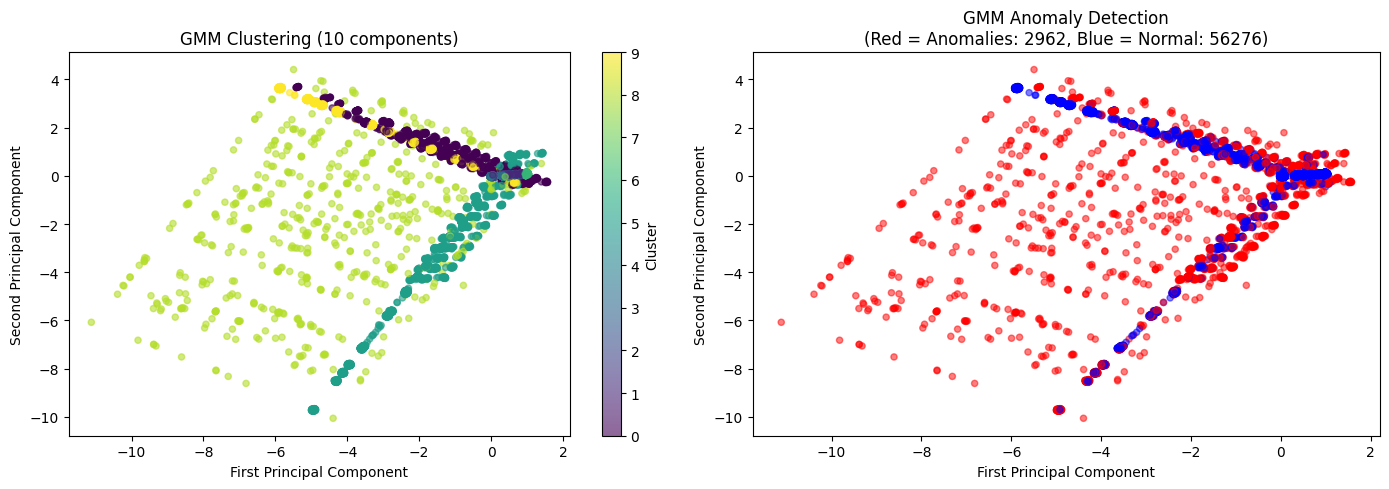

In [147]:
# Visualize GMM clustering and anomalies in PCA space
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# GMM clusters
scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=gmm_labels, cmap='viridis', alpha=0.6, s=20)
axes[0].set_title(f'GMM Clustering ({optimal_n_components} components)')
axes[0].set_xlabel('First Principal Component')
axes[0].set_ylabel('Second Principal Component')
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

# Anomalies vs Normal (color by probability density)
colors = ['red' if anomaly else 'blue' for anomaly in is_anomaly]
axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=colors, alpha=0.5, s=20)
axes[1].set_title(f'GMM Anomaly Detection\n(Red = Anomalies: {is_anomaly.sum()}, Blue = Normal: {(~is_anomaly).sum()})')
axes[1].set_xlabel('First Principal Component')
axes[1].set_ylabel('Second Principal Component')

plt.tight_layout()
plt.show()

Cluster Assignment Uncertainty:
  Highly confident (prob > 0.6): 54998 (92.84%)
  Uncertain (prob < 0.6): 4240 (7.16%)


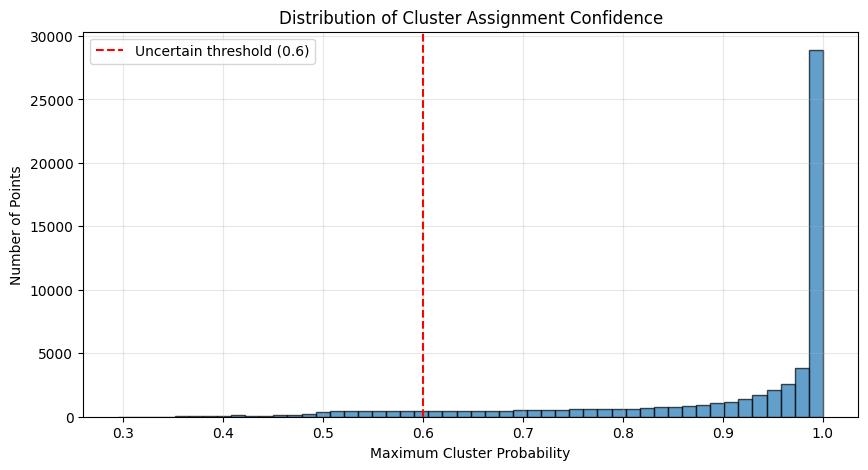

In [148]:
# Compare clustering uncertainty
# Get max probability for each point (confidence in cluster assignment)
max_probs = gmm_probs.max(axis=1)

# Points with low max probability are uncertain
uncertain_threshold = 0.6
uncertain_points = max_probs < uncertain_threshold

print(f'Cluster Assignment Uncertainty:')
print(f'  Highly confident (prob > {uncertain_threshold}): {(~uncertain_points).sum()} ({100*(~uncertain_points).sum()/len(max_probs):.2f}%)')
print(f'  Uncertain (prob < {uncertain_threshold}): {uncertain_points.sum()} ({100*uncertain_points.sum()/len(max_probs):.2f}%)')

# Visualize uncertainty
plt.figure(figsize=(10, 5))
plt.hist(max_probs, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(x=uncertain_threshold, color='r', linestyle='--', label=f'Uncertain threshold ({uncertain_threshold})')
plt.xlabel('Maximum Cluster Probability')
plt.ylabel('Number of Points')
plt.title('Distribution of Cluster Assignment Confidence')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# t-SNE Visualization

t-SNE (t-Distributed Stochastic Neighbor Embedding) is a powerful technique for visualizing high-dimensional data in 2D or 3D. Unlike PCA which is linear, t-SNE:
- Preserves local structure (nearby points stay nearby)
- Reveals clusters and patterns better than PCA
- Is non-linear and can capture complex relationships

**Important:** t-SNE is for visualization ONLY, not for feature engineering (it's non-deterministic and doesn't preserve global distances).

In [149]:
from sklearn.manifold import TSNE

# Apply t-SNE for 2D visualization
# Note: t-SNE can be slow on large datasets, so we use a subset if needed
n_samples_tsne = min(10000, len(X_scaled))
print(f'Applying t-SNE on {n_samples_tsne} samples...')

# Sample data if needed
if len(X_scaled) > n_samples_tsne:
    indices = np.random.choice(len(X_scaled), n_samples_tsne, replace=False)
    X_tsne_input = X_scaled[indices]
    gmm_labels_tsne = gmm_labels[indices]
    kmeans_labels_tsne = sklearn_kmeans_labels[indices]
else:
    X_tsne_input = X_scaled
    gmm_labels_tsne = gmm_labels
    kmeans_labels_tsne = sklearn_kmeans_labels

# Fit t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000, verbose=1)
X_tsne = tsne.fit_transform(X_tsne_input)

print(f't-SNE embedding shape: {X_tsne.shape}')

Applying t-SNE on 10000 samples...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.009s...


C:\Users\mazen\AppData\Roaming\Python\Python312\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computed neighbors for 10000 samples in 1.501s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.464733
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.566444
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.566444
[t-SNE] KL divergence after 1000 iterations: 1.671507
t-SNE embedding shape: (10000, 2

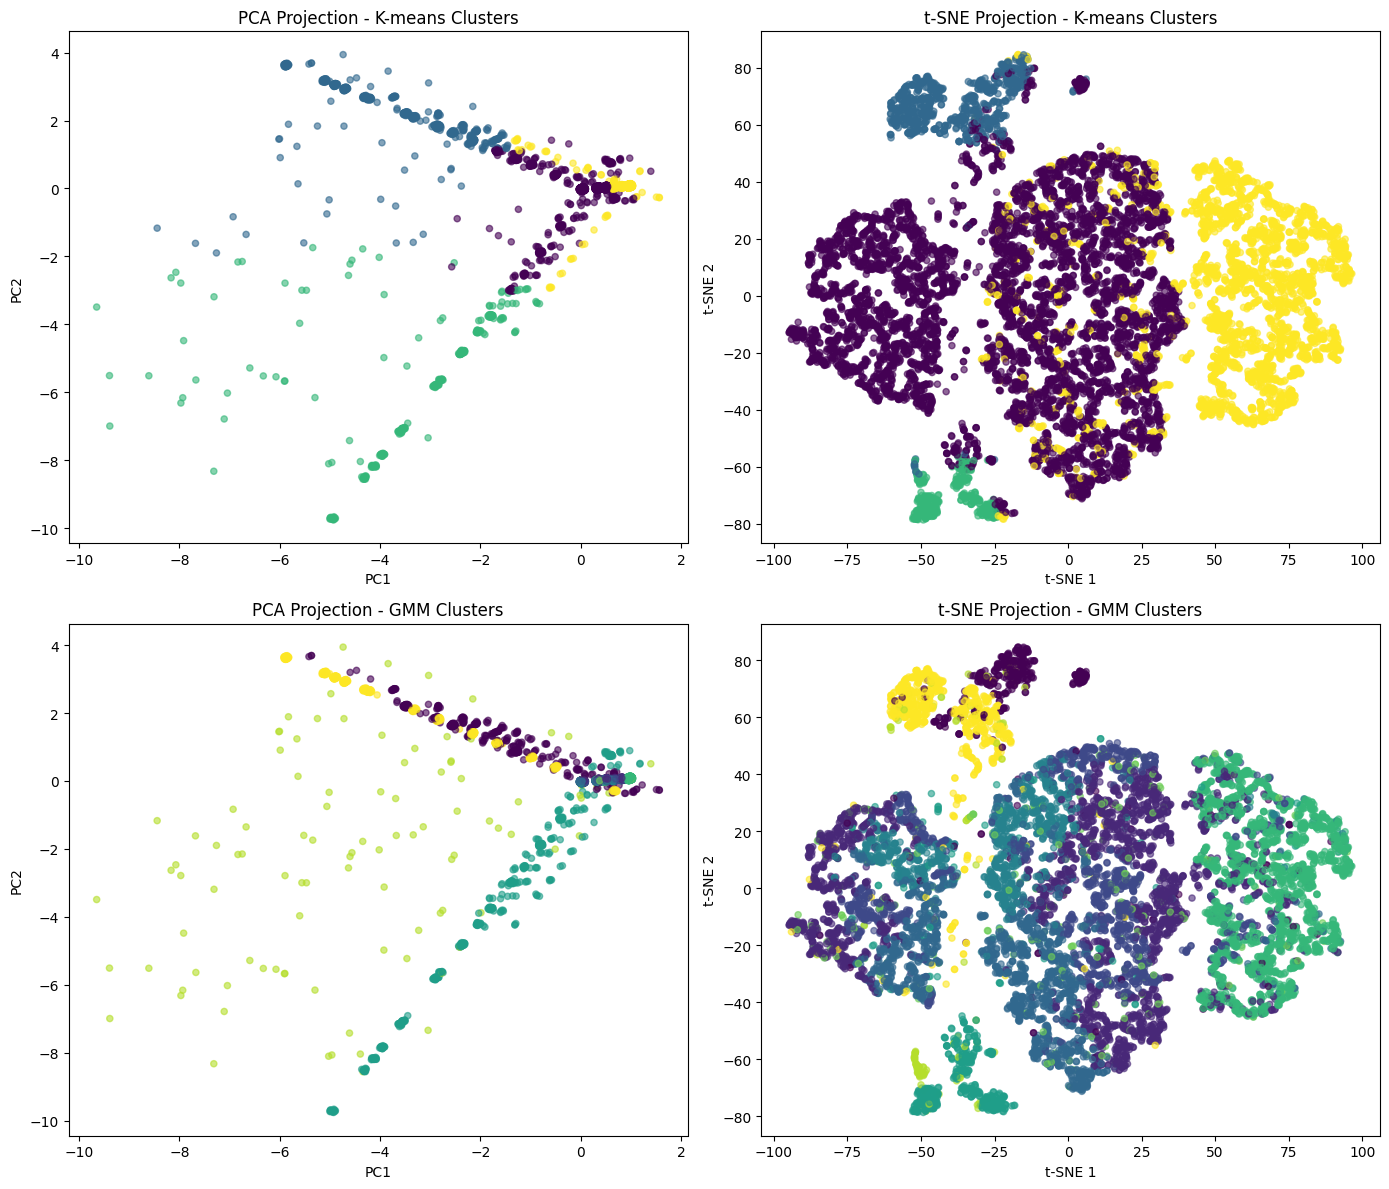

\nVisualization Comparison:
- PCA: Linear projection, preserves global structure
- t-SNE: Non-linear embedding, preserves local structure and reveals clusters better


In [150]:
# Compare t-SNE with PCA visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Get PCA projection for same samples
if len(X_scaled) > n_samples_tsne:
    X_pca_subset = X_pca[indices]
else:
    X_pca_subset = X_pca

# Row 1: K-means clusters
axes[0, 0].scatter(X_pca_subset[:, 0], X_pca_subset[:, 1], 
                   c=kmeans_labels_tsne, cmap='viridis', alpha=0.6, s=20)
axes[0, 0].set_title('PCA Projection - K-means Clusters')
axes[0, 0].set_xlabel('PC1')
axes[0, 0].set_ylabel('PC2')

axes[0, 1].scatter(X_tsne[:, 0], X_tsne[:, 1], 
                   c=kmeans_labels_tsne, cmap='viridis', alpha=0.6, s=20)
axes[0, 1].set_title('t-SNE Projection - K-means Clusters')
axes[0, 1].set_xlabel('t-SNE 1')
axes[0, 1].set_ylabel('t-SNE 2')

# Row 2: GMM clusters
axes[1, 0].scatter(X_pca_subset[:, 0], X_pca_subset[:, 1], 
                   c=gmm_labels_tsne, cmap='viridis', alpha=0.6, s=20)
axes[1, 0].set_title('PCA Projection - GMM Clusters')
axes[1, 0].set_xlabel('PC1')
axes[1, 0].set_ylabel('PC2')

axes[1, 1].scatter(X_tsne[:, 0], X_tsne[:, 1], 
                   c=gmm_labels_tsne, cmap='viridis', alpha=0.6, s=20)
axes[1, 1].set_title('t-SNE Projection - GMM Clusters')
axes[1, 1].set_xlabel('t-SNE 1')
axes[1, 1].set_ylabel('t-SNE 2')

plt.tight_layout()
plt.show()

print('\\nVisualization Comparison:')
print('- PCA: Linear projection, preserves global structure')
print('- t-SNE: Non-linear embedding, preserves local structure and reveals clusters better')

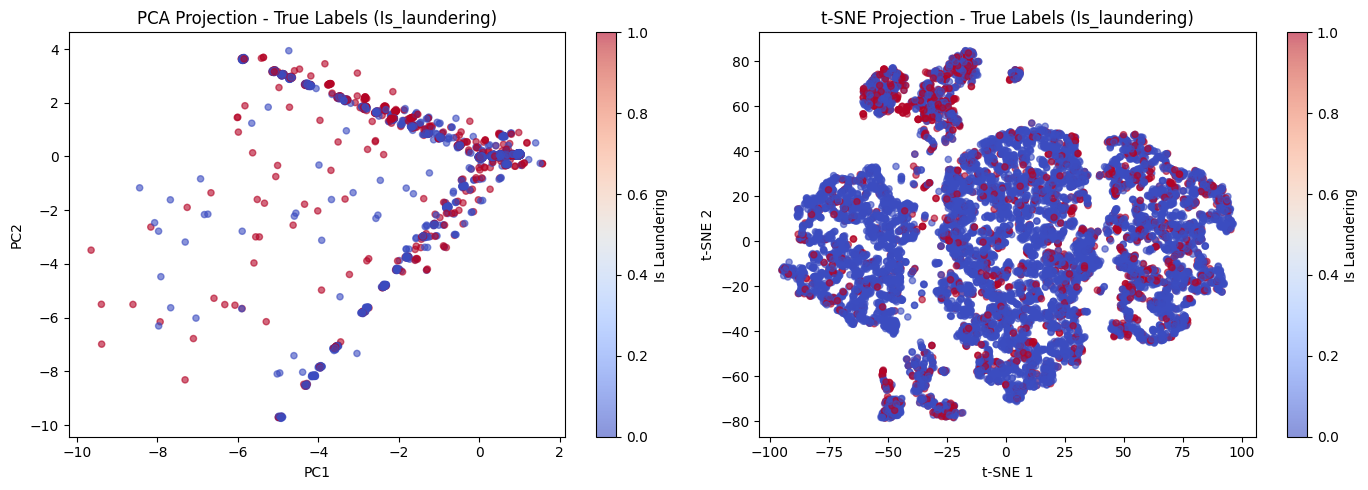

\nCluster Quality Assessment:
True laundering cases: 1658 (16.58%)
True legitimate cases: -11658 (-116.58%)


In [151]:
# Visualize with actual labels if available
if 'Is_laundering' in df_sample.columns:
    # Get labels for the t-SNE subset
    if len(X_scaled) > n_samples_tsne:
        true_labels = df_sample['Is_laundering'].values[indices]
    else:
        true_labels = df_sample['Is_laundering'].values
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # PCA with true labels
    scatter1 = axes[0].scatter(X_pca_subset[:, 0], X_pca_subset[:, 1], 
                               c=true_labels, cmap='coolwarm', alpha=0.6, s=20)
    axes[0].set_title('PCA Projection - True Labels (Is_laundering)')
    axes[0].set_xlabel('PC1')
    axes[0].set_ylabel('PC2')
    plt.colorbar(scatter1, ax=axes[0], label='Is Laundering')
    
    # t-SNE with true labels
    scatter2 = axes[1].scatter(X_tsne[:, 0], X_tsne[:, 1], 
                               c=true_labels, cmap='coolwarm', alpha=0.6, s=20)
    axes[1].set_title('t-SNE Projection - True Labels (Is_laundering)')
    axes[1].set_xlabel('t-SNE 1')
    axes[1].set_ylabel('t-SNE 2')
    plt.colorbar(scatter2, ax=axes[1], label='Is Laundering')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate how well clusters align with true labels
    print('\\nCluster Quality Assessment:')
    print(f'True laundering cases: {true_labels.sum()} ({100*true_labels.sum()/len(true_labels):.2f}%)')
    print(f'True legitimate cases: {(~true_labels).sum()} ({100*(~true_labels).sum()/len(true_labels):.2f}%)')
else:
    print('No true labels (Is_laundering) available for comparison')

## Summary and Key Findings

Summary of what we learned from implementing and comparing clustering algorithms.

### Key Findings:

**K-means Clustering:**
- **Manual Implementation**: Simple iterative algorithm that assigns points to nearest centroids and updates centroids
- **Sklearn Implementation**: Much faster due to optimized C/Cython code
- **Elbow Method**: Helps find optimal number of clusters by looking for the "elbow" in the inertia curve
- **Use Case**: Works well when clusters are spherical and roughly equal sized

**DBSCAN Clustering:**
- **Manual Implementation**: Finds dense regions by checking neighbors within a radius (eps)
- **Sklearn Implementation**: Uses efficient data structures (KD-trees) for much faster neighbor searches
- **Parameter Tuning**: eps controls neighborhood size, min_samples controls density threshold
- **Use Case**: Good for finding arbitrary-shaped clusters and identifying outliers (noise points)
- **For AML**: Successfully identified and removed noise points from the dataset

**GMM (Gaussian Mixture Models):**
- **Soft Clustering**: Provides probabilities of cluster membership rather than hard assignments
- **Model Selection**: BIC/AIC scores help determine optimal number of components
- **Anomaly Detection**: Points with low probability density are potential anomalies/fraud
- **Use Case**: Better than K-means for overlapping clusters and uncertainty quantification
- **For AML**: Can identify suspicious transactions based on low probability scores

**t-SNE (t-Distributed Stochastic Neighbor Embedding):**
- **Visualization Only**: Non-linear dimensionality reduction for visualization (NOT for features)
- **Better Clustering Visualization**: Reveals local structure and clusters better than PCA
- **Comparison with PCA**: PCA preserves global structure (linear), t-SNE preserves local neighborhoods (non-linear)
- **Use Case**: Understanding data structure, presenting findings, validating clustering results
- **For AML**: Helps visualize separation between legitimate and fraudulent transactions

**Manual vs Sklearn:**
- Manual implementations help understand the algorithms deeply
- Sklearn implementations are production-ready, optimized, and much faster
- Manual DBSCAN is particularly slow (O(n²)) without spatial indexing
- Sklearn uses advanced optimizations (vectorization, compiled code, smart data structures)

**Key Insights for AML Detection:**
1. **DBSCAN effectively identifies outliers** - removed noise points that could be anomalies
2. **GMM provides anomaly scores** - useful for ranking suspicious transactions
3. **t-SNE confirms cluster separation** - shows that fraudulent and legitimate transactions have different patterns
4. **Multiple clustering approaches** provide complementary insights into transaction behavior